In [1]:
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

To start we just compare DisARM and Bitflip + joint strategy. We need a model with K realistically large, say 100. We can explore multiple functions f


$$f_1(z; t) = \sum_{j=1}^k (z_j - t_j)^2 $$

$$f_2(z; t) = (z-t)^tC(z-t) $$
Bitflip-1
- sample random $j \in {1, \dots, K}$
- sample $z \sim p$
- $g_j = K*[(1- t_j)^2 - (t_j)^2]$
- $g_{-j} = 0$

Bitflip-k
- sample $z \sim p$
- $g_j = [(1- t_j)^2 - (t_j)^2]$

DisARM
- sample uniforms $U_j$
- $z_j = 1\{U_j < \theta_j \}$, $\tilde{z}_j = 1\{1 - U_j < \theta_j \}$
- $g_j \leftarrow \frac{1}{2} ( f(z; t) - f(\tilde{z}; t))\frac{1}{\theta_1 1\{\theta_1 < 0.5\} + (1-\theta_1) 1\{\theta_1 \geq 0.5\}} \mathbf{1}_{z_j \neq \tilde{z}_j} (-1)^{\tilde{z}_j}$


Bitflip-opt(1)
- if $ 2K\geq 1/min(\theta_j, 1- \theta_j) $, run DisARM o.w. run bitflip 

In [60]:
K = 20
t_ = 0.49
t = np.array(K*[t_])

In [61]:
def f(z,t):
    return ((z-t)**2).sum()

In [62]:
def sampleDisARM(theta,t):
    u = np.random.uniform(size= K)
    #z = np.array([1.0 if u[j] < theta[j] else 0.0 for j in range(K)])
    #ztilde = np.array([1.0 if 1.0 - u[j] < theta[j] else 0.0 for j in range(K)])
    z = (u < theta).astype(int)
    ztilde = (1.0 - u < theta).astype(int)
    diff = f(z,t) - f(ztilde,t)
    
    g = np.zeros(K)
    g[theta < 0.5] = 0.5*diff*((-1)**(ztilde[theta<0.5]))*(1/theta[theta<0.5])
    g[theta >= 0.5] = 0.5*diff*((-1)**(ztilde[theta>=0.5]))*(1/(1.0 - theta[theta>=0.5]))
    g[ztilde == z] = 0 
    
    return g
    
def sampleBitFlip_1(theta, t):
    q = np.random.choice(list(range(K)))
    z1 = np.random.binomial(n=1, p = theta[q])
    
    g = np.zeros(K)
    g[q] = K*((1-t[q])**2 - t[q]**2)
    return g

def sampleBitFlip_k(theta, t):
    g = ((1-t)**2 - t**2)
    return g


def sampleBitFlip_opt(theta,t):
    g_1 = sampleBitFlip_1(theta,t) #not comparing wall clock so this is ok
    g_2 = sampleDisARM(theta,t)
    use_bitflip = 1/np.min(np.array([theta,1-theta]), axis = 0) >= 2*K
    #print(use_bitflip.mean())
    g = np.zeros(K)
    g[use_bitflip] = g_1[use_bitflip]
    g[~use_bitflip] = g_2[~use_bitflip]
    return g


def sampleReinforce_loo(theta,t):
    z1 = np.random.binomial(n=1, p = theta)
    z2 = np.random.binomial(n=1, p = theta)
    f1 = f(z1,t)
    f2 = f(z2,t)
    return 0.5 * ((f1 - f2) * (z1 - theta)+ (f2 - f1) * (z2 - theta)) *(1/theta)*(1/(1-theta))

def loss(theta, t):
    return (((1-t)**2) * theta + (t**2) * (1-theta)).sum()

In [63]:
def sigma(x):
    return np.exp(x)/(1+np.exp(x))

def train(grad_func,start, t, n_epoch = 1000, learning_rate = 5.0):
    
    losses = []
    thetas = []
    vars_ = []
    phi = start
    
    for i in tqdm(range(n_epoch)):
        theta = sigma(phi)
        g = grad_func(theta, t)
        
        #compute variances:
        g_ss = []
        for j in range(5000):
            g_s = grad_func(theta, t)
            g_ss.append(g_s)
        g_ss = np.array(g_ss)
        vars_.append(np.var(g_ss, axis = 0).mean())
        
            
        phi = phi - learning_rate*g*sigma(phi)*sigma(-1.0*phi)
        
        thetas.append(theta)
        losses.append(loss(theta,t))
    return thetas,losses, np.array(vars_)

def train2(grad_func,start, t, n_epoch = 1000, learning_rate = 0.1):
    
    losses = []
    thetas = []
    vars_ = []
    theta = start
    
    for i in tqdm(range(n_epoch)):
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        g = grad_func(theta, t)
        
        #compute variances:
        g_ss = []
        for j in range(5000):
            g_s = grad_func(theta, t)
            g_ss.append(g_s)
        g_ss = np.array(g_ss)
        vars_.append(np.var(g_ss, axis = 0).mean())
        
            
        theta = theta - learning_rate*g#*sigma(phi)*sigma(-1.0*phi)
        
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        thetas.append(theta)
        losses.append(loss(theta,t))
    return thetas,losses, np.array(vars_)

In [29]:
thetas_o, losses_o, vars_o = train2(sampleBitFlip_opt, start = phi, t=t,learning_rate = 9.0)

100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


In [64]:
phi = sigma(np.random.normal(size = K))
#init = 1/(2*K)
#phi = np.array([np.log(init/(1-init))]*K)

thetas_r, losses_r, vars_r = train2(sampleReinforce_loo, start = phi, t = t, learning_rate =0.8)
thetas_d, losses_d, vars_d = train2(sampleDisARM, start = phi, t = t, learning_rate = 0.8)
thetas_b, losses_b, vars_b = train2(sampleBitFlip_1, start = phi, t = t, learning_rate = 0.8)
thetas_o, losses_o, vars_o = train2(sampleBitFlip_opt, start = phi, t=t,learning_rate = 0.8)



100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s]


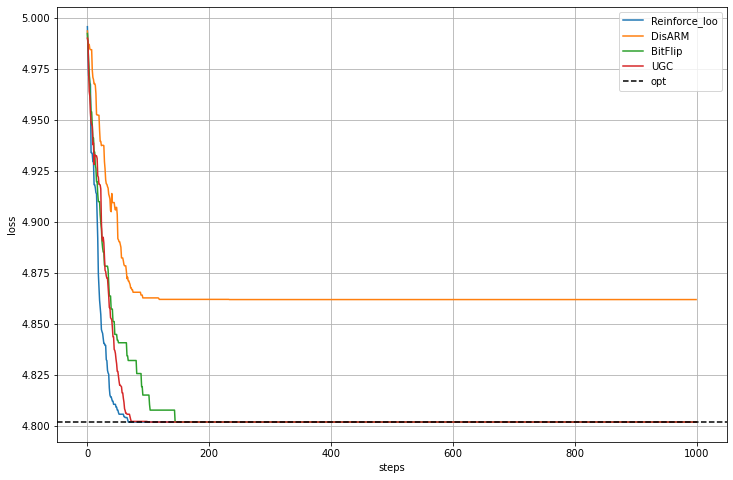

In [68]:
plt.figure(figsize = (12,8))
plt.plot(losses_r, label = "Reinforce_loo")
plt.plot(losses_d, label = "DisARM")
plt.plot(losses_b, label = "BitFlip")
plt.plot(losses_o, label = "UGC")
plt.ylabel("loss")
plt.xlabel("steps")
plt.axhline(K*(t_**2), c = "black", linestyle ="--", label = "opt")
plt.legend()
plt.grid()
plt.savefig("P1loss_49.png", dpi = 300)

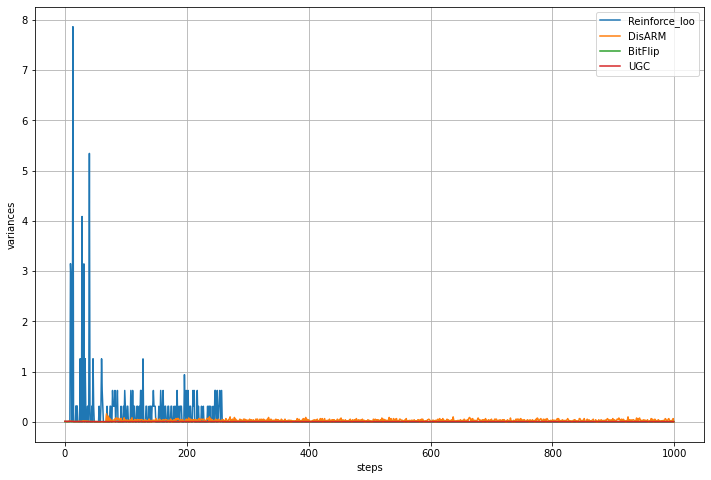

In [67]:
plt.figure(figsize = (12,8))
plt.plot(vars_r, label = "Reinforce_loo")
plt.plot(vars_d, label = "DisARM")
plt.plot(vars_b, label = "BitFlip")
plt.plot(vars_o, label = "UGC")
plt.ylabel("variances")
plt.xlabel("steps")
plt.legend()
plt.grid()
plt.savefig("P1var_49.png", dpi = 300)

In [14]:
N = 50
vars_r[vars_r > 10000] = 10000
vars_d[vars_d > 10000] = 10000
vars_r_new = np.convolve(vars_r, np.ones(N)/N, mode='valid')
vars_d_new = np.convolve(vars_d, np.ones(N)/N, mode='valid')

In [56]:
def save_list(filepath,lst):
    with open(filepath, "w") as f:
        for s in lst:
            f.write(str(s) +"\n")

In [57]:
"""
save_list("thetas_d_l1000.txt",thetas_d)
save_list("losses_d_l1000.txt",losses_d)
save_list("vars_d_l1000.txt",vars_d)

save_list("thetas_b_l1000.txt",thetas_b)
save_list("losses_b_l1000.txt",losses_b)
save_list("vars_b_l1000.txt",vars_b)

save_list("thetas_o_l1000.txt",thetas_o)
save_list("losses_o_l1000.txt",losses_o)
save_list("vars_o_l1000.txt",vars_o)
 """